<h2><b>Dogs Breed Classification</b></h2>

<h3>Importing Libraries</h3>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Define dataset directories
train_dir = "./data/train"
val_dir = "./data/test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")


Number of classes: 120


In [4]:
# Load pre-trained ResNet model
# model = models.resnet18(pretrained=True)
model=models.resnet50(pretrained=True)
# Modify the final fully connected layer for num_classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
num_epochs = 0
best_val_acc = 0.0
checkpoint_path = "best_model50.pth"
# start_epochs=0

# Load the model from checkpoint if available, else trained from scratch.
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epochs=checkpoint['epoch']
    best_val_acc=checkpoint['val_acc']
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with val_acc: {checkpoint['val_acc']:.2f}%")
    model.eval()
except:
    start_epochs=0


# Training and validation loop
for epoch in range(start_epochs,num_epochs):
    # Training phase
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training loss and accuracy
    train_acc = 100 * correct_train / total_train
    avg_train_loss = running_loss / total_train

    # Validation phase
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation loss and accuracy
    val_acc = 100 * correct_val / total_val
    avg_val_loss = running_val_loss / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save checkpoint if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} with val_acc: {val_acc:.2f}%")


C:\Users\vedan\AppData\Local\Temp\ipykernel_8692\4099219533.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from epoch 20 with val_acc: 85.37%


In [7]:
def cleanOutput(x):
    word=x.split("-")
    word=word[1:]
    word=" ".join(word)
    word=word.replace("_"," ")
    return word.title()

# print(f"Predicted class: {cleanOutput(predicted_class)}")

In [14]:
from ultralytics import YOLO
import numpy as np
import json

checkpoint=torch.load("./best_model50.pth")
model=models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features,120)
model.load_state_dict(checkpoint["model_state_dict"])


device="cuda"
yolo=YOLO("yolov8n.pt")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Class names for prediction
class_names = None
with open("./classes.json","r") as file:
    class_names=json.load(file)
    
class_names=class_names["classes"]

In [16]:

def classify(image, model, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    # image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    print(predicted.item())
    predicted_class = class_names[int(predicted.item())]
    return predicted_class


<h3>Using YOLO to detect the multiple dogs in the image and predicting each breed.</h3>

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_array=np.array(image)
        # print(image.shape)
    results = yolo(image,device="cpu")

    dog_class_id = 16

    send_Images=[]
    send_Predictions=[]
    for i, box in enumerate(results[0].boxes.data):
        x1, y1, x2, y2, conf, class_id = box

        if int(class_id) == dog_class_id:
            # Crop and save the detected dog
            cropped_dog = image_array[int(y1):int(y2), int(x1):int(x2)]
            cropped_dog=Image.fromarray(cropped_dog)
            prediction=classify(cropped_dog,model,class_names)
          
            send_Predictions.append(prediction)
            send_Images.append(cropped_dog)
    return send_Images,send_Predictions

In [18]:
# Path to the test image
image_path = "./Customdata/shutterstock_479863729-1000x600sfw.jpg"

(-0.5, 999.5, 599.5, -0.5)

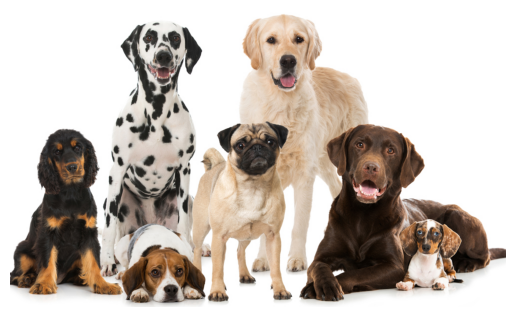

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

img=Image.open(image_path)
plt.imshow(img)
plt.axis("off")

In [20]:
images,predictions=predict_image(image_path)


0: 384x640 7 dogs, 126.2ms
Speed: 10.1ms preprocess, 126.2ms inference, 24.8ms postprocess per image at shape (1, 3, 384, 640)
63
57
95
57
102
11
10


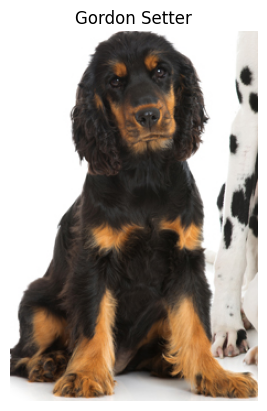

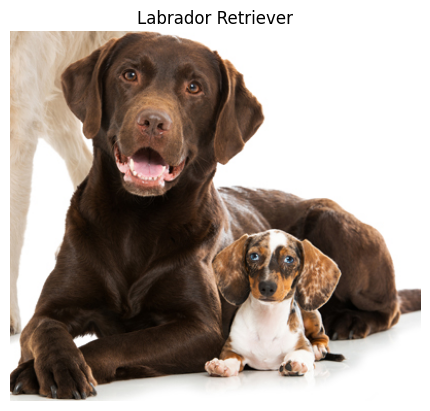

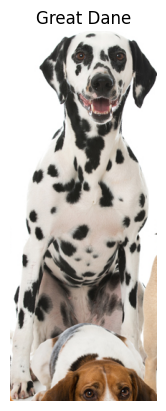

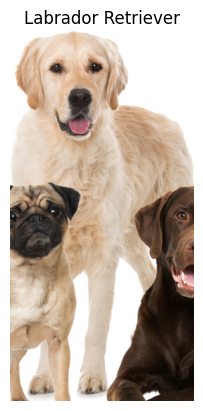

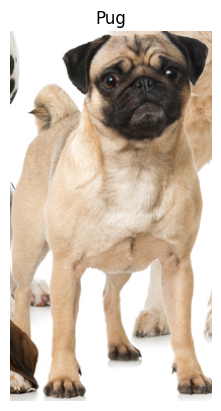

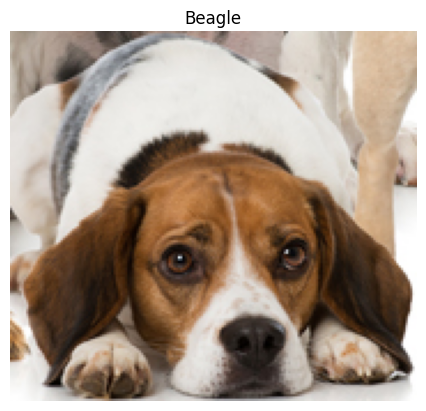

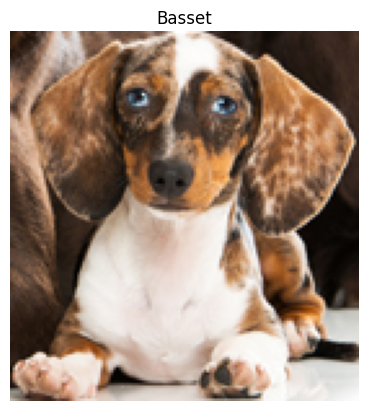

In [21]:
for i in range(0,len(predictions)):
    plt.imshow(images[i])
    plt.title(predictions[i])
    plt.axis("off")
    plt.show()

In [22]:
labels_=[]
predicted_=[]
with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # predicted_.extend(predicted)
            predicted_.extend(predicted.cpu().numpy().tolist())
            labels_.extend(labels.cpu().numpy().tolist())


In [25]:
from sklearn.metrics import classification_report


report = classification_report(labels_, predicted_, output_dict=True)

print("Macro F1-score:", report["macro avg"]["f1-score"])
print("Weighted F1-score:", report["weighted avg"]["f1-score"])
print("Macro Precision:", report["macro avg"]["precision"])
print("Macro Recall:", report["macro avg"]["recall"])
print("Weighted Precision:", report["weighted avg"]["precision"])
print("Weighted Recall:", report["weighted avg"]["recall"])
print("Accuracy:", report["accuracy"])

Macro F1-score: 0.8504026626771147
Weighted F1-score: 0.8527391539626763
Macro Precision: 0.8543131676344783
Macro Recall: 0.8507417705860282
Weighted Precision: 0.8560036489426754
Weighted Recall: 0.8536761172513215
Accuracy: 0.8536761172513215
